### Imports

In [117]:
import os
import glob
import argparse
import time
from PIL import Image
import numpy as np
import PIL
import h5py

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from tensorflow.keras.models import load_model
from layers import BilinearUpSampling2D
from loss import depth_loss_function
from utils import predict
from matplotlib import pyplot as plt

### Load Model

In [118]:
# Argument Parser
parser = argparse.ArgumentParser(description='High Quality Monocular Depth Estimation via Transfer Learning')
parser.add_argument('--model', default='nyu.h5', type=str, help='Trained Keras model file.')
parser.add_argument('--traininput', default='training_images/*.jpg', type=str, help='Training input filename or folder.')
parser.add_argument('--testinput', default='testing_image/*.jpg', type=str, help='Testing input filename or folder.')
args, unknown = parser.parse_known_args()

# Custom object needed for inference and training
start = time.time()
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(args.model, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(args.model))

Loading model...

Model loaded (nyu.h5).


### Predict Heatmap Image

In [119]:
def load_images_with_resize(image_files):
    loaded_images = []
    for file in image_files:
        im = Image.open( file )
        im = im.resize((640, 480), PIL.Image.ANTIALIAS)
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

# Input images
inputs = load_images_with_resize( glob.glob(args.traininput) )
print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)

end = time.time()
print('It took: ', end - start)


Loaded (1) images of size (480, 640, 3).


c:\Users\nmull\OneDrive\Desktop\Portland State\Computer Imaging\monocular-depth-estimation\env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  """


It took:  71.74440312385559


### Helper Functions

In [120]:
def display_depth(image, title=''):
    """
    Display depth image as a heatmap.
    """
    plt.figure(figsize=(10,5))
    out = plt.imshow(image, cmap='plasma', interpolation='nearest')
    out = plt.colorbar()
    plt.title(title)

def display_rgb(image, title=''):
    """
    Display regular RGB image.
    """
    plt.figure(figsize=(10,5))
    out = plt.imshow(image)
    plt.title(title)

In [121]:
def condense_image(image_src):
    """
    Delete every other row and column of the image array so it matched dimensions
    of our predicted images.
    """
    image = np.copy(image_src)
    for row in reversed(range(len(image))):
        if row % 2 != 0:
            image = np.delete(image, row, 0)

    for column in reversed(range(len(image[0]))):
        if column % 2 != 0:
            image = np.delete(image, column, 1)
    return image

def normalize_image(image):
    """
    Normalizes depth map image to be between 0 and 1.
    """
    min = np.min(image)
    max = np.max(image)
    return (image - min) / (max - min)

In [122]:
def get_ground_truth(index: int):
    """
    Gets single ground truth image from dataset.
    """
    f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
    nyu_depth_image = f['depths'][index]

    return condense_image(nyu_depth_image.T)

def get_ground_truth_images(indices: list):
    """
    Gets ground truth images from dataset using list of indicies.
    """
    ground_truth_images = []
    f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
    for i in indices:
        ground_truth_images.append(condense_image(f['depths'][i].T))
    return ground_truth_images

def get_relative(index: int):
    """
    Grabs jpeg images from /training_images and creates relative depth maps of
    them. Returns array of depth maps.
    """
    f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
    predicted_images = []
    inputs = []

    im = f['images'][index].T
    x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
    inputs.append(x)
    inputs = np.stack(inputs, axis=0)
    outputs = predict(model, inputs)
    
    return normalize_image(np.asarray(outputs[0]))


def get_relative_images(indices: list):
    """
    Creates relative depth maps from database given a list of indices. Returns
    array of depth maps.
    """
    f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
    predicted_images = []
    inputs = []

    for i in indices:
        im = f['images'][i].T
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        inputs.append(x)
    inputs = np.stack(inputs, axis=0)
    outputs = predict(model, inputs)
    
    for i in range(len(outputs)):
        predicted_images.append(normalize_image(np.asarray(outputs[i])))
    return predicted_images

def get_rgb(index: int):
    """
    Returns single RGB image from dataset.
    """
    f = h5py.File('nyu_depth_v2_labeled.mat', 'r')         
    return f['images'][index].T       


def get_rgb_images(indices: list):
    """
    Returns list of RGB images from dataset.
    """
    rgb_images = []
    f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
    for i in indices:
        rgb_images.append(condense_image(f['images'][i]))
    return rgb_images

def get_similar_images(index: int):
    f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
    source_img_max = f['depths'][index].max()
    source_img_min = f['depths'][index].min()
    nyu_images = []
    for i in range(len(f['images'])):
        if(source_img_min - 0.1 <=  f['depths'][i].min() <= source_img_min + 0.1
           and source_img_max - 0.1 <= f['depths'][i].max() <= source_img_max + 0.1):
            nyu_images.append(i)                  
    return nyu_images

### Display Relative and True Depth Image

9
[25, 389, 469, 721, 737, 818, 1020, 1213, 1441]


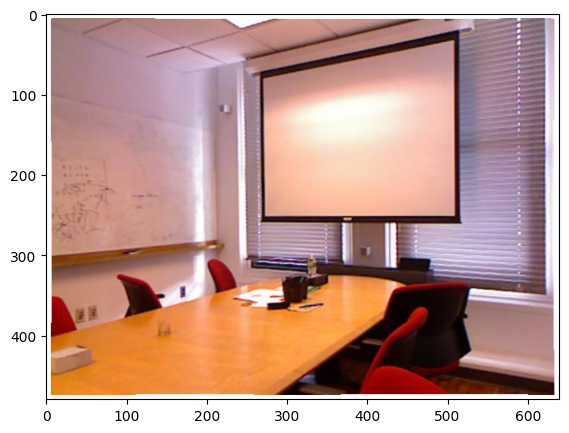

In [123]:
# Normal Image'ArithmeticError
image_index = 25
reference_image = get_rgb(image_index)
display_rgb(reference_image)
similar_images = get_similar_images(image_index)
print(len(similar_images))
test_image = 0
print(similar_images)
if(len(similar_images) > 1):
    test_image = similar_images.pop()


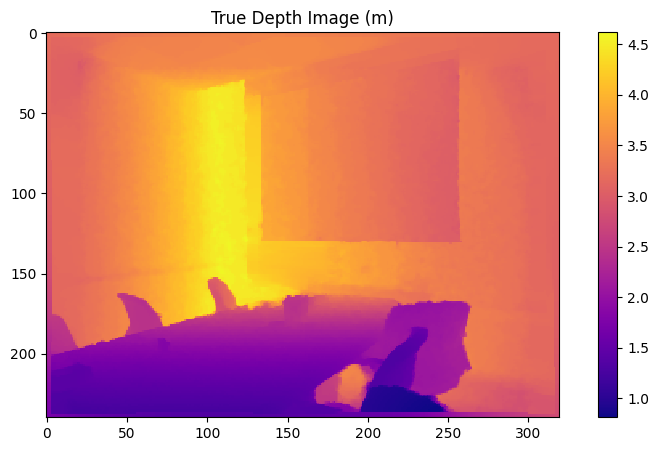

In [124]:
# Display Ground-Truth Image

true_depth_image = get_ground_truth(image_index)
display_depth(true_depth_image, "True Depth Image (m)")

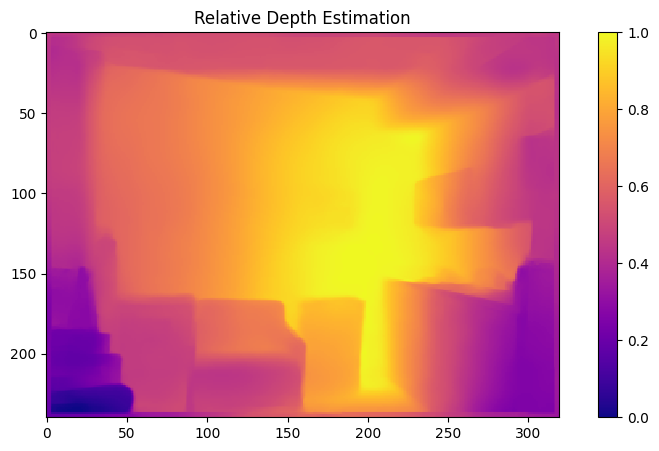

In [125]:
# Display Predicted Image
predicted_image = normalize_image(np.asarray(outputs[0]))
display_depth(predicted_image, "Relative Depth Estimation")

### Calculate Function Between Relative and True Depth For A Single Image

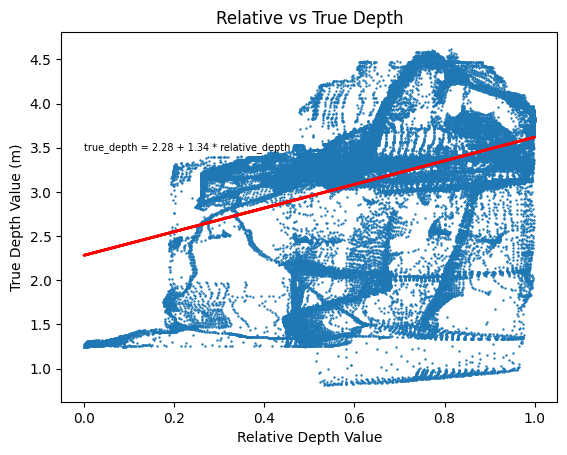

In [126]:
# Display the two images as a function between each other
x_axis = predicted_image.flatten()
y_axis = true_depth_image.flatten()

# Patch-based lines
a, b = np.polyfit(x_axis, y_axis, 1)

plt.scatter(x_axis, y_axis, s=0.5)
plt.title('Relative vs True Depth')
plt.xlabel('Relative Depth Value')
plt.ylabel('True Depth Value (m)')
plt.plot(x_axis, a*x_axis + b, linewidth=2, color='red')
plt.text(0, 3.48, 'true_depth = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + ' * relative_depth', size=7)
plt.show()

### Calculate Function Between Relative and True Depth For Multiple Images

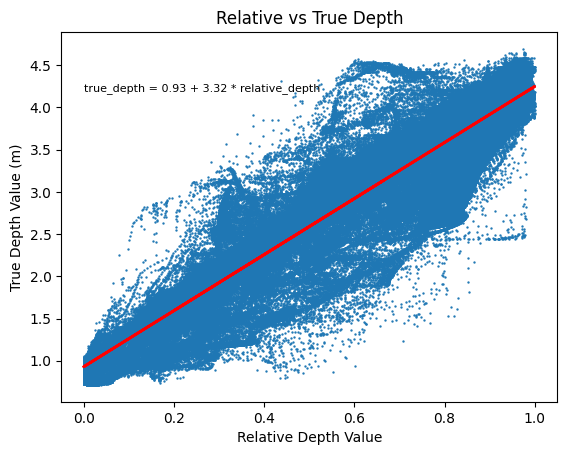

In [127]:
image_indices = similar_images # Indices of photos to use
true_depth_images = get_ground_truth_images(image_indices)
relative_depth_images = get_relative_images(image_indices)

# Display the two types of images as a function between each other
x_axis = []
y_axis = []
for i in range(len(image_indices)):
    x_axis = np.concatenate((x_axis, relative_depth_images[i].flatten()), axis=None)
    y_axis = np.concatenate((y_axis, true_depth_images[i].flatten()), axis=None)

# TODO: Patch-based lines will go here
a, b = np.polyfit(x_axis, y_axis, 1)

plt.scatter(x_axis, y_axis, s=0.5)
plt.title('Relative vs True Depth')
plt.xlabel('Relative Depth Value')
plt.ylabel('True Depth Value (m)')
plt.plot(x_axis, a*x_axis + b, linewidth=2, color='red')
plt.text(0, 4.2, 'true_depth = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + ' * relative_depth', size=8)
plt.show()

### Apply Equation to New Image

1441


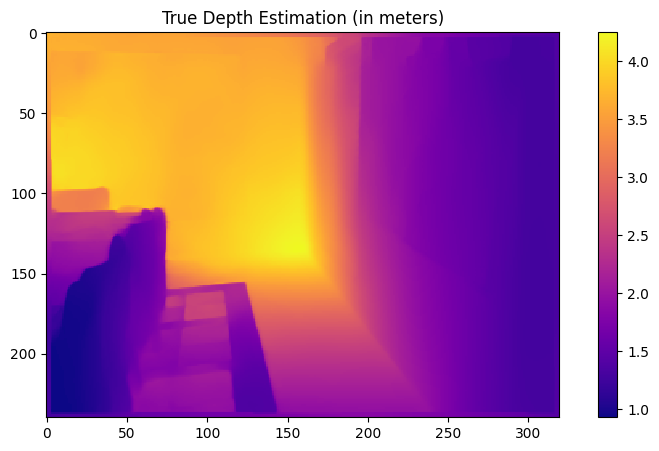

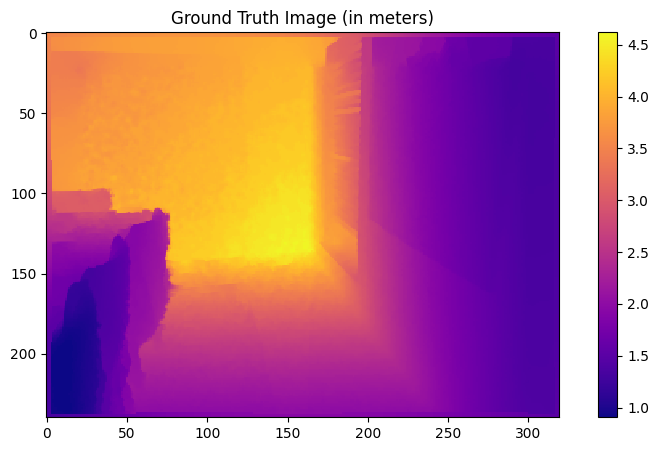

In [128]:
# Test the equation on a new image
image_index = test_image
print(test_image)
ground_truth_image = get_ground_truth(image_index)
relative_depth_image = get_relative(image_index)

# Maybe replace b (our offset) with the closest distance
estimated_true_depth_image = a * relative_depth_image + b

display_depth(estimated_true_depth_image, "True Depth Estimation (in meters)")
display_depth(ground_truth_image, "Ground Truth Image (in meters)")